### Метрики качества классификации.

Сегодня мы научимся использовать различные метрики для оценки качества моделей.

Для начала загрузим данные с предыдущей домашней задачи с небольшим `сюрпризом`. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("processed_train.csv")

In [3]:
data.head()

EngineVersion  AppVersion  AvSigVersion  RtpStateBitfield  \
0       0.552153    0.530941      0.587952               7.0   
1       0.448751    0.528931      0.484434               7.0   
2       0.552153    0.530941      0.557522               7.0   
3       0.552153    0.530941      0.482759               7.0   
4       0.493175    0.530941      0.505721               7.0   

   IsSxsPassiveMode  AVProductStatesIdentifier  AVProductsInstalled  \
0                 0                    53447.0                  1.0   
1                 0                    53447.0                  1.0   
2                 0                    53447.0                  1.0   
3                 0                    53447.0                  1.0   
4                 0                    53447.0                  1.0   

   AVProductsEnabled  HasTpm  CountryIdentifier  ...  Platform_windows8  \
0                1.0       1                 29  ...                  0   
1                1.0       1                 93  ...                  0   
2                1.0       1                 86  ...                  0   
3                1.0       1                 97  ...                  0   
4                1.0       1                164  ...                  0   

   Processor_x64  Processor_x86  Census_DeviceFamily_Windows.Server  \
0              1              0                                   0   
1              1              0                                   0   
2              1              0                                   0   
3              1              0                                   0   
4              1              0                                   0   

   Census_OSArchitecture_arm64  Census_OSArchitecture_x86  \
0                            0                          0   
1                            0                          0   
2                            0                          0   
3                            0                          0   
4                            0                          0   

   Census_GenuineStateName_IS_GENUINE  Census_GenuineStateName_OFFLINE  \
0                                   1                                0   
1                                   0                                1   
2                                   1                                0   
3                                   1                                0   
4                                   1                                0   

   Census_GenuineStateName_UNKNOWN  HasDetections  
0                                0              0  
1                                0              0  
2                                0              0  
3                                0              0  
4                                0              0  

[5 rows x 79 columns]

Один из гномов очень завидовал своим братьям, переплюнувшим его по `accuracy` в бонусном задании предыдущей домашней работы. Поэтому совершил следующее злодеяние: выкинул кучу объектов таким образом, чтобы баланс классов нарушился! 

`Может, accuracy у них станет еще больше, зато преподаватель их отругает, ведь использовать accuracy при дисбалансе не очень-то хорошо!` - подумал гном

Замерьте количество объектов в порченном датафрейме.
В какой пропорции соотносятся классы теперь?

In [4]:
### Your code is here
print(f"Количество объектов в датафрейме: {data.shape[1]}\nКлассы: {data['HasDetections'].value_counts()}\nИ их соотношение: {data['HasDetections'].value_counts()[0]/data['HasDetections'].value_counts()[1]:.3f}")

Количество объектов в датафрейме: 79
Классы: HasDetections
0    99940
1    20012
Name: count, dtype: int64
И их соотношение: 4.994


Произведем процедуру отложенной выборки:

In [5]:
y = data['HasDetections']
X = data.drop('HasDetections', axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test  = train_test_split(X, y, 
                                                     test_size=0.25, 
                                                     shuffle=True, 
                                                     random_state=1)

Обучите логистическую регрессию с параметром `l2` регуляризации `C = 0.01` на порченном датасете.
Замерьте долю верно классифицированных объектов на трейне и на тесте. Можете использовать абсолютно любые конструкции, главное не забыть пронормировать данные с помощью `StandardScaler`

In [6]:
### Your code is here
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate

pipe = Pipeline([('Scaler', StandardScaler()),
                 ('LR', LogisticRegression(penalty='l2',
                                           C=0.01))])

custom_cv = [(X_train.index.to_list(), X_test.index.to_list())]

cross_val = cross_validate(pipe, X, y, scoring='accuracy',
                           cv=custom_cv, return_train_score=True)

print(f"Accuracy на трейне: {np.mean(cross_val['train_score']).round(3)}")
print(f"Accuracy на тесте: {np.mean(cross_val['test_score']).round(3)}")

Accuracy на трейне: 0.841
Accuracy на тесте: 0.842


Кажется, что, по сравнению с результатами в предыдущей домашней работе, мы построили куда более сильную модель. Но мы сильно заблуждаемся, если в это верим!

**Задание 2.**
Для бинарной классификации можно построить так называемую **confision matrix** (матрица ошибок), которая подсчитывает количество правильных и неправильных предсказаний и разделяет их по двум классам:

|          | a(x) = -1  | a(x) = +1  |
|----------|------------|------------|
|  y = -1  |     TN     |     FP     |
|  y = +1  |     FN     |     TP     |

* Positive/Negative отражает то, к какому классу определила объект наша модель $a(x)$, в нашем случае нулевой класс соответствует Negative (нет вируса), а единичный класс - Positive (есть вирус).

* True/False просто показывает совпало ли предсказание модели с реальным классом объекта, поэтому на главной диагонали стоят True, а на побочной False.

**2.1)** Постройте вручную матрицу ошибок на тестовой выборке, используя реальные и предсказанные вашей моделью метки классов. Потом сравните результат с методом `confusion_matrix` в `sklearn`.

In [7]:
pipe.fit(X_train, y_train)
pred_test = pipe.predict(X_test)

### Your code is here

tp = ((pred_test == 1) * (y_test == 1)).sum()
tn = ((pred_test == 0) * (y_test == 0)).sum()
fp = ((pred_test == 1) * (y_test == 0)).sum()
fn = ((pred_test == 0) * (y_test == 1)).sum()

np.array([[tn, fp], [fn, tp]])


array([[24726,   293],
       [ 4442,   527]], dtype=int64)

In [8]:
from sklearn.metrics import confusion_matrix

### Your code is here
tn, fp, fn, tp = confusion_matrix(y_test, pred_test).ravel()

print(f'True Negative errors: {tn}')
print(f'False Positive errors: {fp}')
print(f'False Negative errors: {fn}')
print(f'True Positive errors: {tp}')

True Negative errors: 24726
False Positive errors: 293
False Negative errors: 4442
True Positive errors: 527


**2.2)** Посчитайте стандартную метрику Accuracy на тестовой выборке c помощью матрицы ошибок. Напомним, что это просто доля верно предсказанных меток:
$
ACC = \dfrac{TP + TN}{TP + TN + FP + FN}
$.

(Не стоит переводить accuracy как точность, так как под точностью иногда еще понимают precision, который является совсем другим показателем! Лучше всегда использовать английские версии метрик, чтобы не возникало недопониманий. )

In [9]:
### Your code is here
manual_accuracy = ((tp + tn) / (tp + tn + fp + fn)).round(3)
manual_accuracy

0.842

Мы ожидаем, что полученная accuracy совпадет с той, что была подсчитана во время использования функции `cross_validate`

Мы знаем, что accuracy не является хорошим показателем качества модели при несбалансированных классах. 

Допустим у нас 1000 объектов, где 990 имеют метку класса 0, а остальные 10 имеют метку 1. В нашем случае, класс 0 соответствует компьютерам, на которых нет вируса, а класс 1 - на которых есть. Тогда accuracy у константной модели, которая всегда предсказывает нулевой класс будет $0.99$, хотя задача как раз состоит в том, чтобы детектировать эти самые 10 объектов, которые соответствуют зараженным компьютерам. 

При несбалансированных выборках с помощью матрицы ошибок можно посчитать следующие метрики:

* **Precision** показывает "точность" попадания нашего классификатора в положительный класс, то есть долю правильно предсказанных положительных объектов среди всех **предсказанных** положительных объектов. 

* **Recall** показывает "полноту" предсказаний нашего классификатора, то есть долю правильно предсказанных положительных объектов среди всех **реальных** положительных объектов.

**2.3)** Посчитайте Precision и Recall с помощью матрицы ошибок. Потом сравните с реализацией в sklearn. Напомним формулы из лекции:

$$
Precision = \dfrac{TP}{TP + FP}, \quad Recall = \dfrac{TP}{TP + FN}
$$

In [10]:
c_matrix = confusion_matrix(y_test, pred_test)

In [11]:
from sklearn.metrics import recall_score, precision_score

### Your code is here

recall = recall_score(y_test, pred_test)
precision = precision_score(y_test, pred_test)

manual_precision = c_matrix[1, 1] / c_matrix[:, 1].sum()
manual_recall = c_matrix[1, 1] / c_matrix[1].sum()

print(f"Precision в sklearn: {precision:.3f}, precision посчитанное вручную {manual_precision:.3f}")
print(f"Recall в sklearn: {recall:.3f}, recall посчитанный вручную {manual_recall:.3f}")

Precision в sklearn: 0.643, precision посчитанное вручную 0.643
Recall в sklearn: 0.106, recall посчитанный вручную 0.106


Теперь картина кажется не такой уж лучезарной!

Вспомним, 

Метод `.predict` на самом деле берёт предсказанные вероятности для каждого класса и каждому объекту присваивает тот класс, у которого больше вероятность. 

Так как мы сейчас занимаемся бинарной классификацией, то большая вероятность определяется просто сравнением с порогом 0.5.

**2.4)** Воспользуйтесь методом `.predict_proba` и с помощью сравнения с порогом 0.5 постройте вектор предсказаний. Проверьте результат на ранее предсказанных метках, вектора должны совпадать.

In [12]:
### Your code is here
pred_probs = pipe.predict_proba(X_test)
np.all((pred_probs[:, 0] < 0.5) == pred_test)

True

**Задание 3.**
Решим бизнес задачу. \
**3.1)** Допустим, заказчик требует, чтобы наш классификатор в 60% случаев правильно предсказывал наличие вируса на компьютере, чтобы не беспокоить клиентов из-за ложноположительных результатов. \
Как решить эту задачу? =>
Надо подобрать порог, который максимизирует `recall` при условии, что `precision > 0.6`.

$$
(recall | precision > 0.6) \to \max_{thres}
$$

In [13]:
from sklearn.metrics import precision_recall_curve

### Строим всевозможные комбинации precision, recall, threshold

precision, recall, thres = precision_recall_curve(y_test, pred_probs[:, 1])

### Находим такую тройку, при которой recall максимален, а precision > 0.6

ind = np.where(recall == recall[precision > 0.6].max())

print(f"Precison:\t {precision[ind][-1]}")
print(f"Recall: \t {recall[ind][-1]}")
print(f"Threshold:\t {thres[ind][-1]}")

Precison:	 0.6003717472118959
Recall: 	 0.1300060374320789
Threshold:	 0.45766970448073596


Теперь чтобы соответствовать установленным условиям, мы будем замерять вероятности для объектов и сравнивать и с найденным `Threshold`, который решает нашу задачу

**3.2)** Аналогично решите задачу, где заказчик требует, чтобы наш классификатор находил хотя бы 20% компьютеров с вирусом, среди всех действительно зараженных компьютеров.
$$
(precision | recall > 0.2) \to \max_{thres}
$$

In [14]:
### Your code is here
precision, recall, thres = precision_recall_curve(y_test, pred_probs[:, 1])

ind = np.where(recall == recall[precision > 0.2].max())

print(f"Precison:\t {precision[ind][-1]}")
print(f"Recall: \t {recall[ind][-1]}")
print(f"Threshold:\t {thres[ind][-1]}")

Precison:	 0.20014395609339153
Recall: 	 0.8953511772992554
Threshold:	 0.09490200731008944


**Задание 4.** На самом деле, можно объединить предыдущие две задачи и максимизировать взвешенную метрику, которая учитывает и Precision, и Recall. \
Посчитайте три такие метрики: среднее арифметическое, среднее геометрическое и минимум. 
1) Найдите порог, который их максимизирует. 
2) Выведите precision и recall, соответствующие этому порогу. 
3) Нарисуйте линии уровня для каждой из этих метрик, используя функцию `level_lines`. 
4) Изобразите точку $(recall, precision)$ соответствующую этому порогу на графике линий уровня.

$$
Arithm_{avg} = \dfrac{P + R}{2}, \quad Geom_{avg} = \sqrt{P \cdot R}, \quad Min = \min(P, R)
$$


In [15]:
def level_lines(func, name):
    x = np.linspace(0, 1.1, 100)
    y = np.linspace(0, 1.1, 100)
    
    X, Y = np.meshgrid(x, y)
    Z = func(X, Y)
    
    plt.figure(figsize=(5, 5))
    plt.title(name)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.contour(X, Y, Z, 15, cmap='plasma');

In [16]:
### Покажем на примере среднего арифметического, что должно у вас получиться

metric_func = lambda x, y: (x + y)/2

arithm_idx = (metric_func(precision, recall)).argmax()

print(f"Precision:\t {precision[arithm_idx]:.3f}")
print(f"Recall: \t {recall[arithm_idx]:.3f}")
print(f"Threshold:\t {thres[arithm_idx]:.3f}")

level_lines(metric_func, "Arithmetic AVG")
plt.plot(recall[arithm_idx], precision[arithm_idx], 'ro');

Precision:	 0.170
Recall: 	 0.998
Threshold:	 0.022


In [17]:
### Повторите для среднего геометрического
### Your code is here
metric_func = lambda x, y: np.sqrt(x * y)

geom_idx = (metric_func(precision, recall)).argmax()

print(f"Precision:\t {precision[geom_idx]:.3f}")
print(f"Recall: \t {recall[geom_idx]:.3f}")
print(f"Threshold:\t {thres[geom_idx]:.3f}")

level_lines(metric_func, "Geom")
plt.plot(recall[geom_idx], precision[geom_idx], 'ro');

Precision:	 0.223
Recall: 	 0.812
Threshold:	 0.125


Precision:	 0.359
Recall: 	 0.359
Threshold:	 0.237


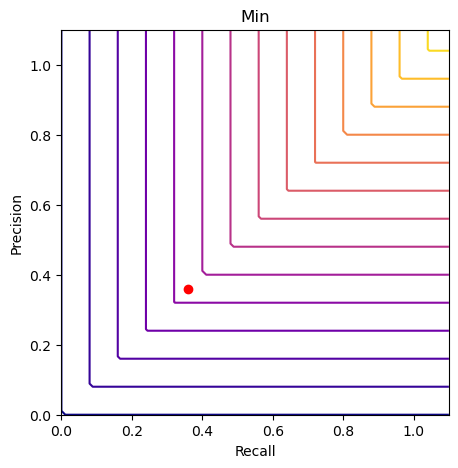

In [18]:
### Повторите для минимума
### Your code is here
metric_func = lambda x, y: np.minimum(x, y)

min_indx = (metric_func(precision, recall)).argmax()

print(f"Precision:\t {precision[min_indx]:.3f}")
print(f"Recall: \t {recall[min_indx]:.3f}")
print(f"Threshold:\t {thres[min_indx]:.3f}")


level_lines(metric_func, "Min")
plt.plot(recall[min_indx], precision[min_indx], 'ro');

**Задание 5.** Одним из самых распространенных показателей качества является **F-мера**, которая обобщает все вышерассмотренные метрики. Более того, в ней можно регулировать параметр $\beta^2$, который отвечает за предпочтение между precision и recall. 
$$
F = \dfrac{(1 + \beta^2) P \cdot R}{\beta^2 P + R}
$$
* При $\beta^2 = 1$ и precision, и recall нам важны в равной степени.
* При $\beta^2 > 1$ предпочтение отдается recall. Похоже на решение задачи, где мы фиксируем приемлемое для нас значение precision и максимизируем recall.
* При $0 < \beta^2 < 1$ предпочтение отдается precision. Похоже на решение задачи, где мы фиксируем приемлемое для нас значение recall и максимизируем precision.

Найдите порог, который максимизирует:
1) F-меру с $\beta^2 = 1$,
2) F-меру с $\beta^2 = 0.05$,
3) F-меру с $\beta^2 = 4$.\
Для всех трех случаев выведите precision, recall, threshold и F-меру. 
Нарисуйте линии уровня и точку, которая максимизирует F-меру по аналогии с предыдущим пунктом.

In [19]:
import warnings
warnings.filterwarnings('ignore')

Precision:	 0.285
Recall: 	 0.525
Threshold:	 0.192
F-мера: 	 0.369


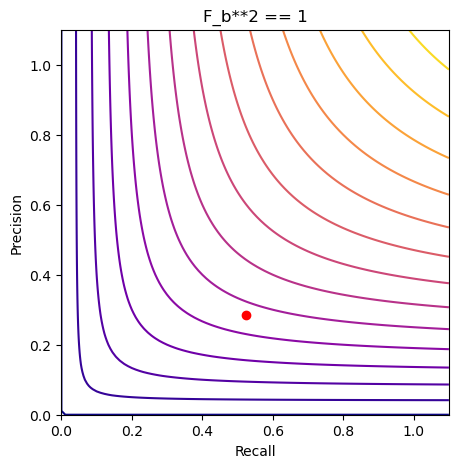

In [20]:
### Повторите для F-меры при \beta^2=1
### Выведите ее вместе с precision/recall/threshold
### Your code is here
f_metric_1 = lambda p, r: (2 * p * r) /(1 * p + r)

f1_indx = (f_metric_1(precision, recall)).argmax()

print(f"Precision:\t {precision[f1_indx]:.3f}")
print(f"Recall: \t {recall[f1_indx]:.3f}")
print(f"Threshold:\t {thres[f1_indx]:.3f}")
print(f"F-мера: \t {f_metric_1(precision, recall)[f1_indx]:.3f}")


level_lines(f_metric_1, "F_b**2 == 1")
plt.plot(recall[f1_indx], precision[f1_indx], 'ro');

In [21]:
### Повторите для F-меры при \beta^2=0.05
### Выведите ее вместе с precision/recall/threshold
### Your code is here
f_metric_2 = lambda p, r: ((1 + 0.5) * p * r) / (0.5*p + r) 

f2_indx = (f_metric_2(precision, recall)).argmax()

print(f"Precision:\t {precision[f2_indx]:.3f}")
print(f"Recall: \t {recall[f2_indx]:.3f}")
print(f"Threshold:\t {thres[f2_indx]:.3f}")
print(f"F-мера: \t {f_metric_2(precision, recall)[f2_indx]:.3f}")


level_lines(f_metric_2, "F_b**2 == 0.5")
plt.plot(recall[f2_indx], precision[f2_indx], 'ro');




Precision:	 0.364
Recall: 	 0.350
Threshold:	 0.240
F-мера: 	 0.359


Precision:	 0.210
Recall: 	 0.863
Threshold:	 0.108
F-мера: 	 0.532


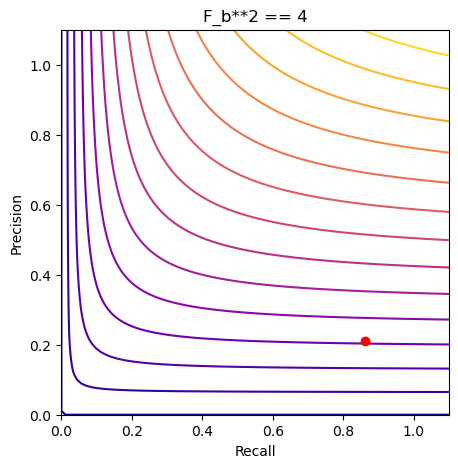

In [22]:
### Повторите для F-меры при \beta^2=4
### Выведите ее вместе с precision/recall/threshold
### Your code is here

f_metric_3 = lambda p, r: ((1 + 4) * p * r) / (4 * p + r)

f3_indx = (f_metric_3(precision, recall)).argmax()

print(f"Precision:\t {precision[f3_indx]:.3f}")
print(f"Recall: \t {recall[f3_indx]:.3f}")
print(f"Threshold:\t {thres[f3_indx]:.3f}")
print(f"F-мера: \t {f_metric_3(precision, recall)[f3_indx]:.3f}")

level_lines(f_metric_3, "F_b**2 == 4")
plt.plot(recall[f3_indx], precision[f3_indx], "ro");